# Credit Risk ML Use Case

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import tree

#### The data is coming from the [Kaggle challenge](https://www.kaggle.com/c/GiveMeSomeCredit), which requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

## Load Data

In [4]:
### load data
df = pd.read_csv(
    'cs-training.csv', 
    sep = ',',
    header = 0)
df = df.drop(
    df.columns[0], 
    axis = 1)

In [5]:
### shape of the data
df.shape

(150000, 11)

So in training dataset, we have 150000 customers with 11 predictors

Use `SeriousDlqin2yrs` as the default label, i.e. target variable. Now check the default rate in the training dataset.

In [6]:
df['SeriousDlqin2yrs'].describe()

count    150000.000000
mean          0.066840
std           0.249746
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: SeriousDlqin2yrs, dtype: float64

Th default rate is 6.684%, implying this is an imbalanced classification problem. You can revisit the dataset later when we finish the discussions about the imbalanced classification topic.
By the way, 6.684% default rate in credit card portfolio is actually much higher than the actual numbers in big banks. Therefore, in reality the degree of imbalance is even more severe.

## Data Summary

In [7]:
### have a glance at the data summary
df.describe().round(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.00,150000.00,150000.00,150000.00,150000.00,120269.00,150000.00,150000.00,150000.00,150000.00,146076.00
mean,0.07,6.05,52.30,0.42,353.01,6670.22,8.45,0.27,1.02,0.24,0.76
std,0.25,249.76,14.77,4.19,2037.82,14384.67,5.15,4.17,1.13,4.16,1.12
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.03,41.00,0.00,0.18,3400.00,5.00,0.00,0.00,0.00,0.00
50%,0.00,0.15,52.00,0.00,0.37,5400.00,8.00,0.00,1.00,0.00,0.00
75%,0.00,0.56,63.00,0.00,0.87,8249.00,11.00,0.00,2.00,0.00,1.00
max,1.00,50708.00,109.00,98.00,329664.00,3008750.00,58.00,98.00,54.00,98.00,20.00


## Data Pre-processing

It is ALWAYS necessary and important to do EDA (exploratory data analysis) and data cleaning before throwing data into the models. Otherwise, it could be "garbage-in and garbage-out". What's more, a small mistake at this level can be costly. For example, the cases where `age` = 0 should be removed. 

In [8]:
df = df[df.age > 0] 

In [9]:
### check missing variables and missing percentages
df.apply(lambda x: sum(x.isnull().values), axis = 0)/df.shape[0]

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198208
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026160
dtype: float64

Around 19.8% of people do not have `MonthlyIncome` (could be an issue since `MonthlyIncome` is generally believed as an important predictor). The median values by each group (i.e. default/non-default) is chosen to fill in the NAs. Be careful that in order to do it, you have to split your data into training and testing first. If you wish to impute this variable by the median value across all data, regardless of the default status, splitting is not required. (Why?)

26% of samples do not have `NumberOfDependents` info. By default, we fill in 0. 



In [10]:
# fill NAs
df.NumberOfDependents = df.NumberOfDependents.fillna(0)

In [11]:
# split data into training(70%) and testing(30%); set a random seed for the sake of reproducibility
train, test = train_test_split(df, test_size = 0.3, random_state = 2017)

In [12]:
# fill missing income by the median values in different groups
income_med = train.groupby('SeriousDlqin2yrs')['MonthlyIncome'].transform('median')
train_NoMissing = train.copy()
train_NoMissing.loc[:, 'MonthlyIncome'] = train['MonthlyIncome'].fillna(income_med)


# do the same thing for testing data
income_med = test.groupby('SeriousDlqin2yrs')['MonthlyIncome'].transform('median')
test_NoMissing = test.copy()
test_NoMissing.loc[:, 'MonthlyIncome'] = test['MonthlyIncome'].fillna(income_med)

In [13]:
### check missing values again
print(sum(train_NoMissing['MonthlyIncome'].isnull()))
print(sum(test_NoMissing['MonthlyIncome'].isnull()))

0
0


In [14]:
features = np.array(['RevolvingUtilizationOfUnsecuredLines',
                     'DebtRatio',
                     'MonthlyIncome',
                     'NumberOfDependents',
                     'NumberOfOpenCreditLinesAndLoans',
                     'NumberOfTime30-59DaysPastDueNotWorse',
                     'NumberOfTime60-89DaysPastDueNotWorse',
                     'NumberOfTimes90DaysLate',
                     'NumberRealEstateLoansOrLines',
                     'age'
                    ])

## Random Forest

In [13]:
print ('----------RandomForest----------\n')

rf_clf = RandomForestClassifier(
        n_estimators = 100, # number of trees in the forest, default is 10
        max_features = 'sqrt', # number of features to be splitted on each node
        n_jobs = -1, # the number of jobs is set to the number of cores
        oob_score = True, # whether to use out-of-bag samples to estimate the generalization accuracy
        random_state = 2017,
        class_weight = 'balanced_subsample' # to address the imbalanced issue
        )
    
rf_clf.fit(train_NoMissing[features], train_NoMissing['SeriousDlqin2yrs'])
rf_predictedValue = rf_clf.predict_proba(test_NoMissing[features]) # prediction

# check the variable importance
importance = rf_clf.feature_importances_
importance = pd.DataFrame(importance, 
                          columns=["Importance"],
                          index = features
                         )

----------RandomForest----------



In [14]:
print(importance.ix[:, 0])

RevolvingUtilizationOfUnsecuredLines    0.240213
DebtRatio                               0.147075
MonthlyIncome                           0.172972
NumberOfDependents                      0.029457
NumberOfOpenCreditLinesAndLoans         0.069128
NumberOfTime30-59DaysPastDueNotWorse    0.085975
NumberOfTime60-89DaysPastDueNotWorse    0.048428
NumberOfTimes90DaysLate                 0.080288
NumberRealEstateLoansOrLines            0.028810
age                                     0.097653
Name: Importance, dtype: float64


In [15]:
y_true = test_NoMissing['SeriousDlqin2yrs']
y_scores = rf_predictedValue[:,1]
'AUC using Random Forest is %.4f' % roc_auc_score(y_true, y_scores)

'AUC using Random Forest is 0.8639'

## Gradient Boosting

In [16]:
print ('----------Gradient Boosting----------\n')

gb_clf = GradientBoostingClassifier(
    n_estimators = 100, #number of boosting stages to perform
    learning_rate = 0.01,
    random_state = 2017,
    max_features = 'sqrt',
    max_depth = 3 #maximum depth of the individual regression estimators, default is 3
)

gb_clf.fit(train_NoMissing[features], train_NoMissing['SeriousDlqin2yrs'])
gb_predictedValue = gb_clf.predict_proba(test_NoMissing[features])

----------Gradient Boosting----------



In [17]:
y_scores = gb_predictedValue[:,1]
'AUC using Gradient Boosting is %.4f' % roc_auc_score(y_true, y_scores)

'AUC using Gradient Boosting is 0.8746'

## Some Exercises

- Compute accuracy rates for both of two models above.
- Perform feature selection by Information Value (will be covered soon)
- Use the selected features only, tune the parameter `max_features` in random forest by cross validation. What is the final AUC and accuracy rate?
- Use the selected features only, tune the parameters `max_depth`, `learning_rate` , `n_estimators` in gradient boosting by cross validation What is the final AUC and accuracy rate? (Hint: `sklearn` already provides you with a built-in function to do it.)
- Repeat the process for `AdaBoost` model, how does `AdaBoost` perform compared to gradient boosting? (Hint: function `AdaBoostClassifier`)

## Variable binning

In [13]:
# training data
df = train_NoMissing[features]

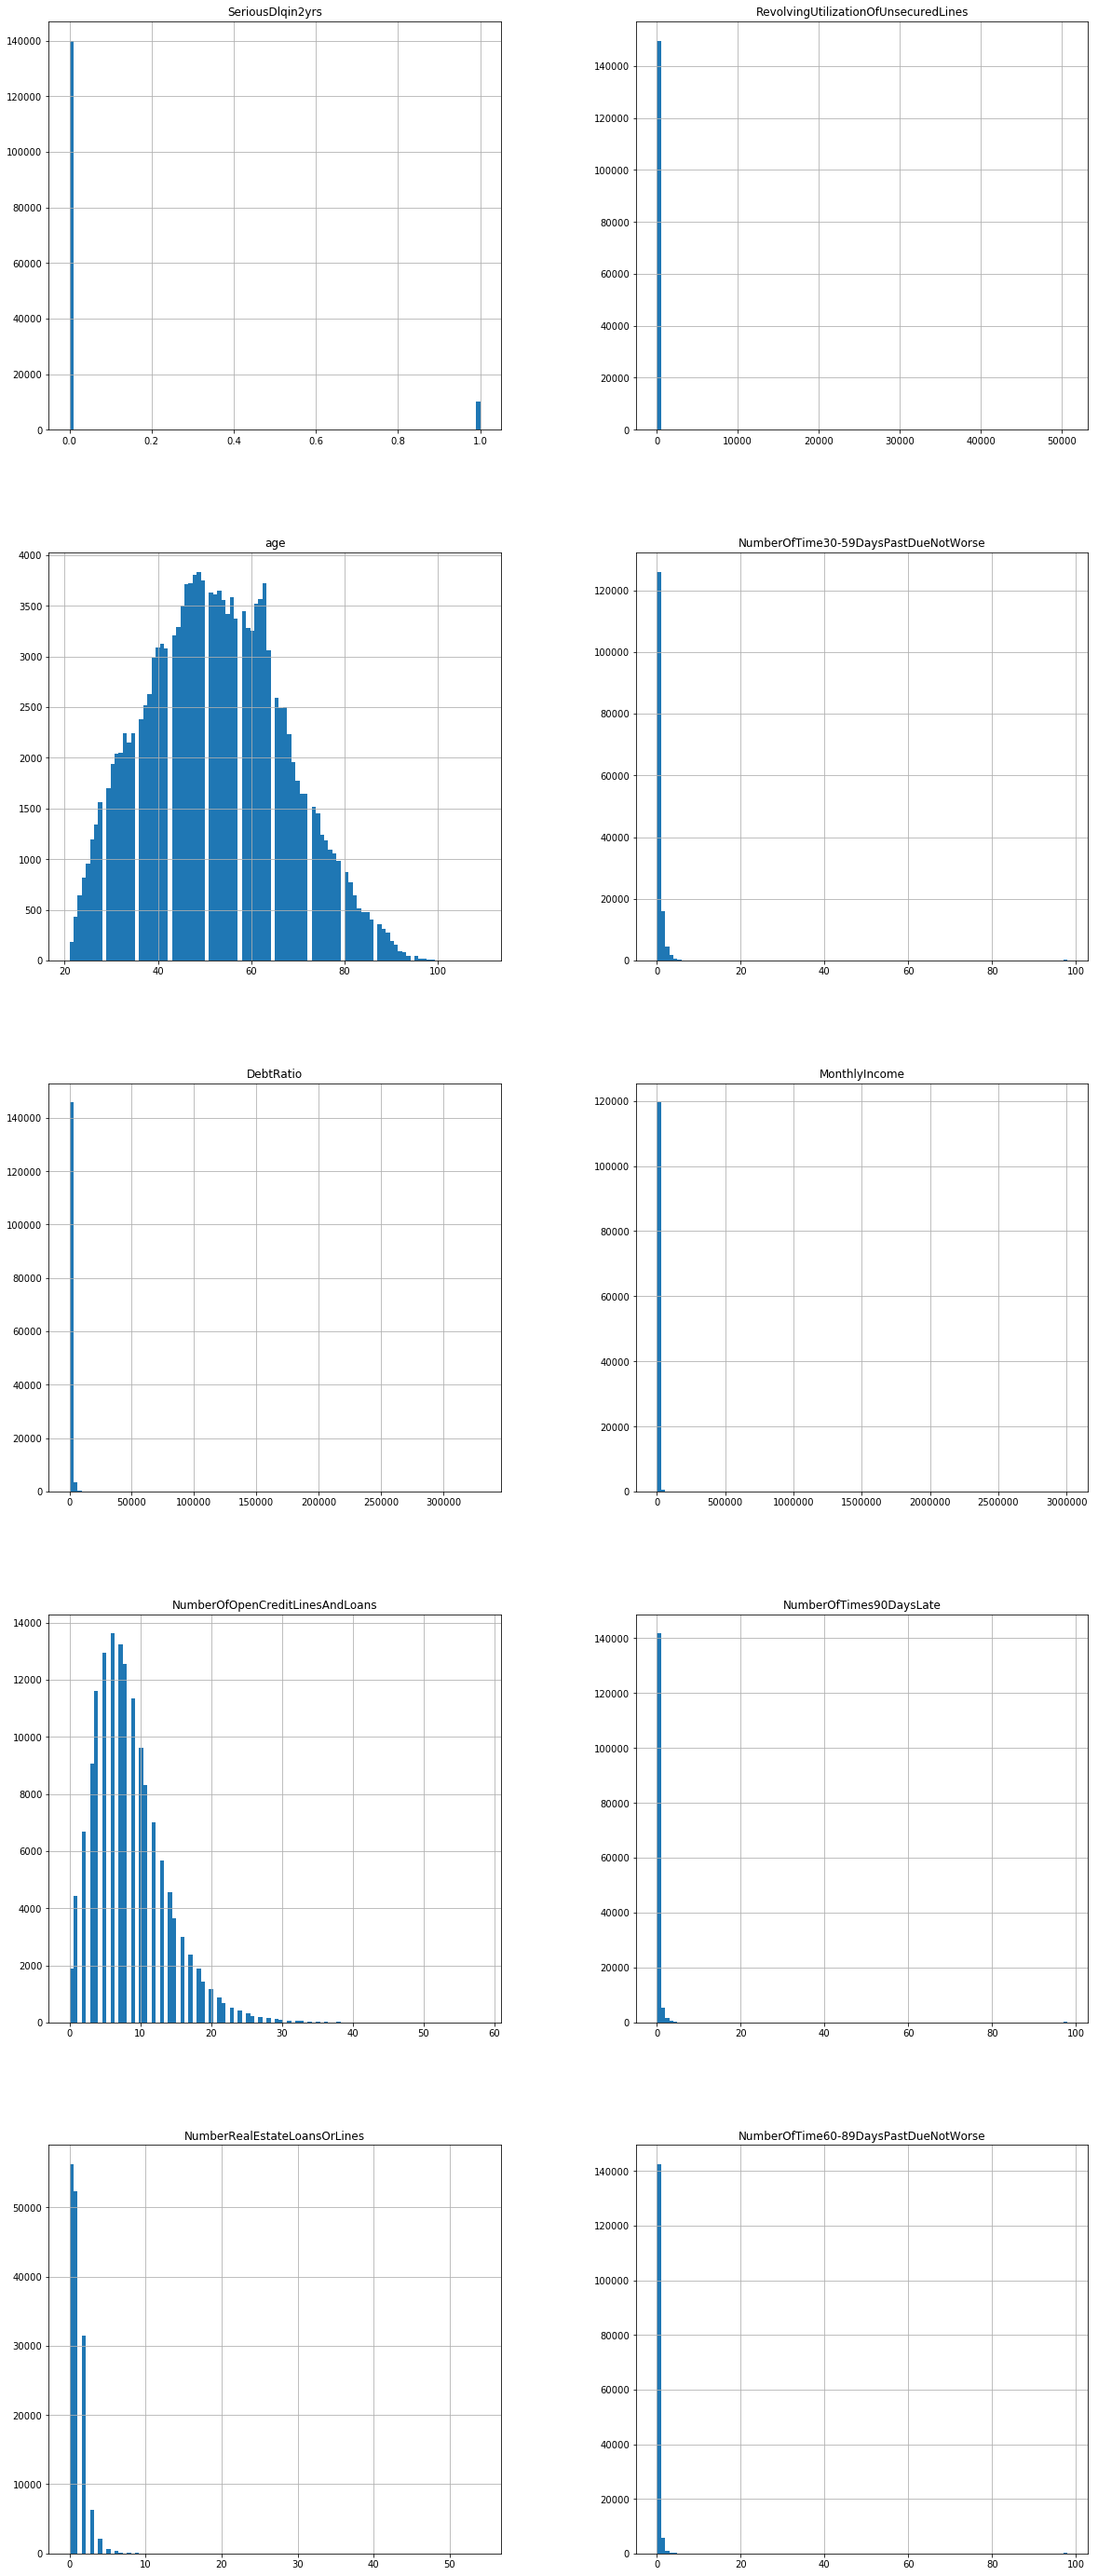

In [15]:
# feature visualization
fig, axes = plt.subplots(len(df.columns)//2, 2, figsize = (20, 50))
i = 0
for triaxis in axes:
    for axis in triaxis:
        df.hist(column = df.columns[i], bins = 100, ax = axis)
        i = i+1

Data are exhibting highly-skewed distribution, indicating binning may be beneficial since it can alleviate impact that outliers/extreme values bring. 

### Binning - take `MonthlyIncome` as an example 

In [16]:
# quantile-based: 5%, 5%-25%, 25%-50%, 50%-80%，80%-95% ，95%+
df = train_NoMissing
q = [df['MonthlyIncome'].quantile(x)  for x in [0.05, 0.25, 0.5, 0.8, 0.95]]
q = sorted(q)
    
def var_binning(x):
    if x <= q[0]:
        y = 'Very Low'
    elif x <= q[1]:
        y = 'Low' 
    elif x <= q[2]:
        y = 'Below Average' 
    elif x <= q[3]:
        y = 'Good' 
    elif x <= q[4]:
        y = 'High' 
    else: y = 'Very High'
        
    return y
        
        
df['MonthlyIncome_bin'] = df['MonthlyIncome'].apply(var_binning)

In [17]:
print(q)

[1500.0, 3900.0, 5473.0, 8275.0, 13500.299999999974]


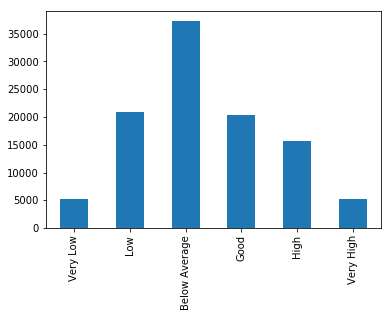

In [18]:
# plot distribution
temp = df.MonthlyIncome_bin.value_counts()
temp.index = pd.CategoricalIndex(temp.index, 
                               categories = ['Very Low', 'Low', 'Below Average', 'Good', 'High', 'Very High'], 
                               sorted = True)
temp = temp.sort_index()
temp.plot(kind = 'bar');

### Information Value

In [19]:
def flag(x):
    if x == 1: 
        y = 'bad' 
    else: 
        y = 'good'
    return y    


df['default'] = df['SeriousDlqin2yrs'].apply(flag)
df['id'] = np.repeat(1, len(df))
                 
table = pd.pivot_table(df, index = ['MonthlyIncome_bin', 'default'],
                       values = ['id'], aggfunc = 'count')
table

id
MonthlyIncome_bin default       
Below Average     bad       2406
                  good     34889
Good              bad       1279
                  good     19161
High              bad        726
                  good     15023
Low               bad       2018
                  good     18944
Very High         bad        253
                  good      4997
Very Low          bad        357
                  good      4946

In [20]:
# column sums
colSums = df.groupby('default').id.sum()

In [21]:
colSums = pd.DataFrame(colSums)
colSums.columns = ['Sum']
newdf = pd.merge(table, colSums, left_index = True, right_index = True)
# check out the pivot table
newdf

id    Sum
MonthlyIncome_bin default              
Below Average     bad       2406   7039
                  good     34889  97960
Good              bad       1279   7039
                  good     19161  97960
High              bad        726   7039
                  good     15023  97960
Low               bad       2018   7039
                  good     18944  97960
Very High         bad        253   7039
                  good      4997  97960
Very Low          bad        357   7039
                  good      4946  97960

In [22]:
newdf['dis'] = newdf['id']/newdf['Sum']

In [23]:
#def WoE(x, newdf):
#    return (np.log(newdf.loc[x, 'good'].dis)/np.log(newdf.loc[x, 'bad'].dis))*100

In [24]:
#gps = newdf.index.levels[0].values
#gps = sorted(gps)
#woe = [WoE(x = x, newdf = newdf)  for x in gps]
#woe = pd.DataFrame(woe, index = gps, columns = ['woe'])

In [25]:
#woe = woe.reindex(index = newdf.index, level = 0)

In [26]:
#newdf = pd.merge(newdf, woe, left_index = True, right_index = True)

#### compute IV

In [27]:
def compute_IV(x, newdf):
    dis_good = newdf.loc[x, 'good'].dis
    dis_bad = newdf.loc[x, 'bad'].dis
    iv = (dis_good-dis_bad)*np.log(dis_good/dis_bad)
    return iv
    
gps = newdf.index.levels[0].values    
IV = sum([compute_IV(x = x, newdf = newdf)  for x in gps])

In [28]:
IV

0.063546945470747088

### Discussions

- `MonthlyIncome` seems to be a weak predictor according to its IV ~ 0.06
- Different ways to binning this variable lead to different conclusion.
- Rule of thumb: the final binned varaible distribution should make *business* sense. So visualization comes to play an important role here. (Part of the reason why banks are choosing Xeno because its interactive visualization allow analysts to explore the dynamics of a model’s score distribution and its separation strength.)
- Instead of quantile-based binning method, you may want to try the decision-tree based binning rule.

## Use the model

- Who are using our model?
- Pass the model output to each product's strategy team to help them make more informed business decisions.


## Model validation

- Each model is subject to approval by senior management, internal and external model validation/auditor.
- Backtesting is a crucial step to prove our model.
- How? Test on scoring applications and accounts from the past and measure model performance on metrics like Kolomogorov Smirnov statistic (K-S), Area under ROC curve (AUC).
- A decent scorecard model should have good backtesting performance.
- Sometimes we also leverage the backtesting performance to calibrate the model coefficients.